In [44]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import datetime

import statsmodels.tsa.api as smt

In [125]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor


import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

In [103]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

Using TensorFlow backend.
C:\Users\higgleop\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\higgleop\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\higgleop\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\higgleop\anaconda3\lib\site-packages\tensorflow\python\framewo

In [32]:
%matplotlib inline

In [6]:

df_train_raw = pd.read_csv("data/demand-forecasting/train.csv")

#Test has no sales data
df_test_raw = pd.read_csv("data/demand-forecasting/test.csv")

In [23]:
df_train_raw

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [18]:
def monthlySales(raw_data):
    monthly_data = raw_data.copy()
    monthly_data.date = monthly_data.date.apply(lambda x: str(x)[:-3] )
    
    monthly_data = monthly_data.groupby('date')['sales'].sum().reset_index()
    monthly_data.date = pd.to_datetime(monthly_data.date)
    
    return monthly_data

In [24]:
df_train_monthly = monthlySales(df_train_raw)

In [21]:
df_train_monthly.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


#### Convert data to stationary by differencing

In [26]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()

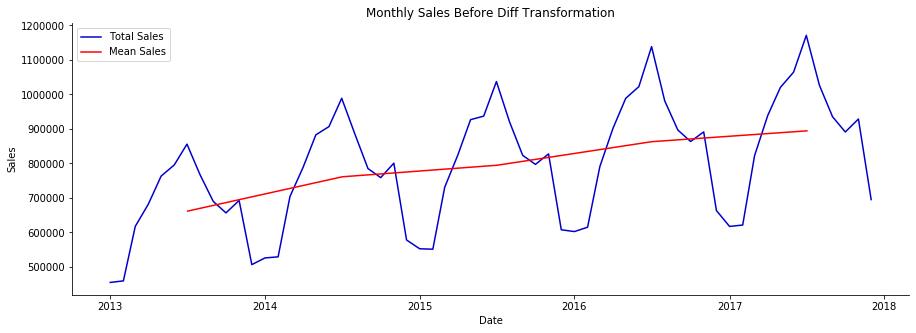

In [34]:

time_plot(df_train_monthly, 'date', 'sales', 'Monthly Sales Before Diff Transformation')

In [40]:
def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv('data/demand-forecasting/stationary_df.csv')
    return data

In [41]:
monthly_diff = get_diff(df_train_monthly)

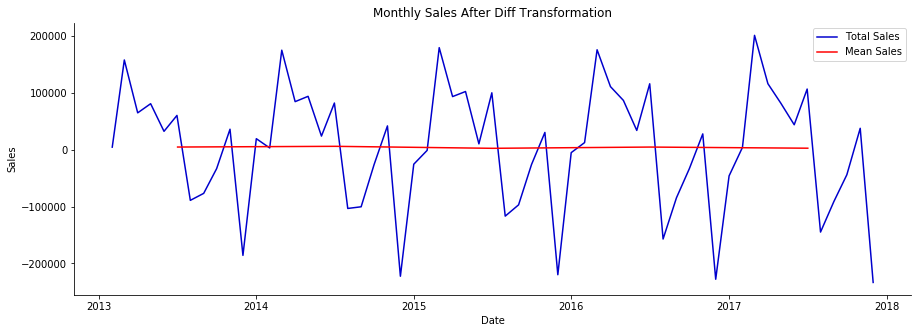

In [42]:
time_plot(monthly_diff , 'date', 'sales_diff', 'Monthly Sales After Diff Transformation')

In [ ]:
### Observing Lags 

In [45]:
def plots(data, lags=None):
    
    # Convert dataframe to datetime index
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    dt_data.plot(ax=raw, figsize=(12, 5), color='mediumblue')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    sns.despine()
    plt.tight_layout()

C:\Users\higgleop\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


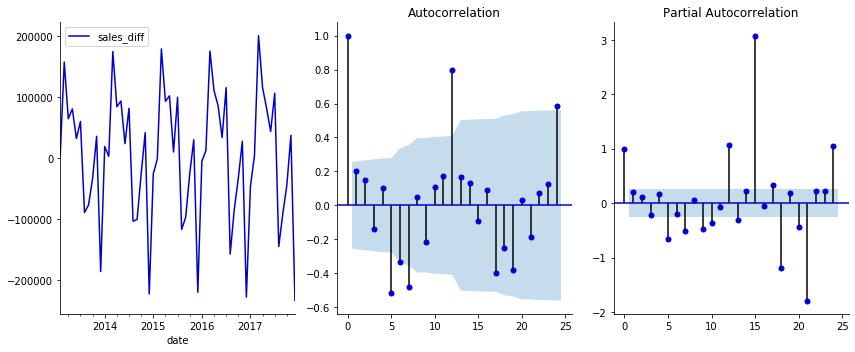

In [46]:
plots(monthly_diff, lags = 24)

### Use 12 months of data as the lag/input

In [47]:
#create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    #supervised_df.to_csv('data/model_df.csv', index=False)
    
    return supervised_df

In [52]:
model_df = generate_supervised(monthly_diff)

In [54]:
#Arima data setup

def generate_arima_data(data):
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    dt_data.to_csv('../data/arima_df.csv')
    
    return dt_data

datetime_df = generate_arima_data(monthly_diff)

In [55]:
#Split last year of data into test
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    
    return train, test

train, test = tts(model_df)

In [56]:
train.shape

(35, 13)

In [58]:

def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('data/demand-forecasting/train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df


In [91]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        a = int(unscaled_predictions[index])
        b = act_sales[index]
        result_dict['pred_value'] = a + b
        #result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [93]:
def get_scores(unscaled_df, original_df, model_name):
    model_scores = {}
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [63]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()

In [68]:
def run_model(train_data, test_data, model, model_name):
    
    #X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    X_train, y_train = train_data[:,1:], train_data[:, 0:1].ravel()
    X_test, y_test = test_data[:,1:], test_data[:, 0:1].ravel()
    
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    #unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(predictions, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

### Linear Regression

RMSE: 16221.190351409685
MAE: 12433.083333333334
R2 Score: 0.9907154167620139


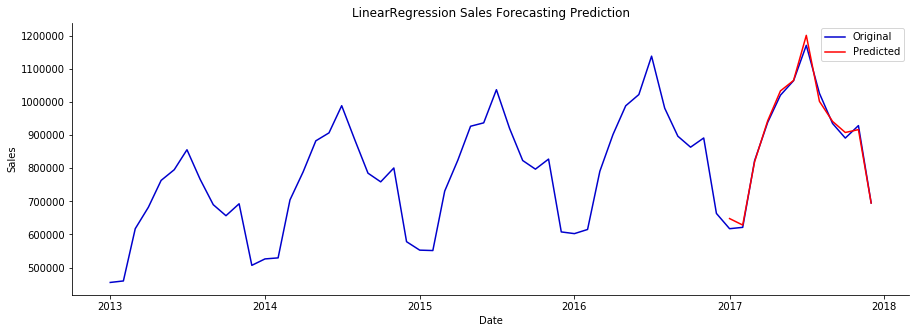

In [94]:
run_model(train, test, LinearRegression(), 'LinearRegression')

### Random Forest Regressor

RMSE: 18607.973935923277
MAE: 15676.5
R2 Score: 0.9877821398162244


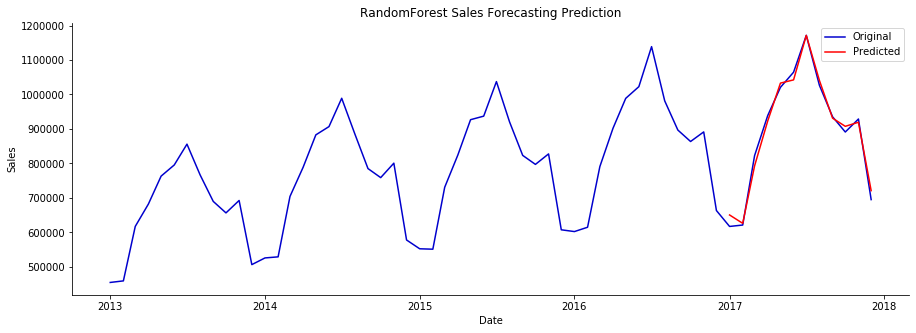

In [96]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

### XGBoost

RMSE: 15070.98202672938
MAE: 12428.75
R2 Score: 0.9919854327646633


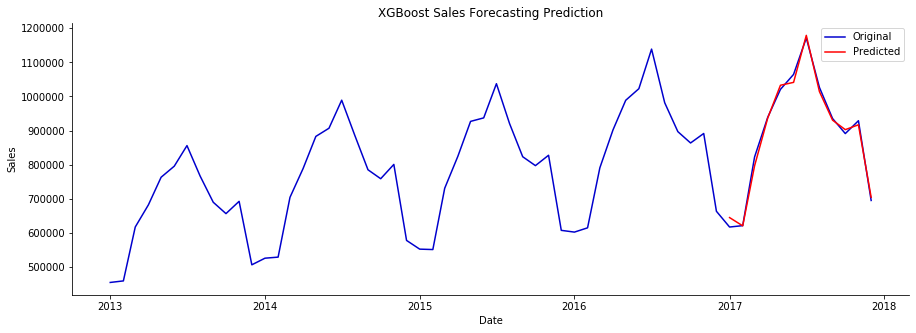

In [99]:
run_model(train, test, XGBRegressor( n_estimators=100, 
                                    learning_rate=0.2, 
                                    objective='reg:squarederror'), 'XGBoost')

### LSTM

In [111]:
def lstm_model(train_data, test_data):
    
    X_train, y_train = train_data[:,1:], train_data[:, 0:1].ravel()
    X_test, y_test = test_data[:,1:], test_data[:, 0:1].ravel()
    
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    #unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(predictions, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')

Epoch 1/200
35/35 [==============================] - 0s 7ms/step - loss: 11819280140.0143
Epoch 2/200
35/35 [==============================] - 0s 785us/step - loss: 11819278880.3929
Epoch 3/200
35/35 [==============================] - 0s 817us/step - loss: 11819278795.7857
Epoch 4/200
35/35 [==============================] - 0s 854us/step - loss: 11819278537.3893
Epoch 5/200
35/35 [==============================] - 0s 960us/step - loss: 11819278300.2571
Epoch 6/200
35/35 [==============================] - 0s 855us/step - loss: 11819278227.8464
Epoch 7/200
35/35 [==============================] - 0s 904us/step - loss: 11819278132.8536
Epoch 8/200
35/35 [==============================] - 0s 826us/step - loss: 11819278100.6679
Epoch 9/200
35/35 [==============================] - 0s 792us/step - loss: 11819277510.1929
Epoch 10/200
35/35 [==============================] - 0s 813us/step - loss: 11819277501.4607
Epoch 11/200
35/35 [==============================] - 0s 798us/step - loss: 11819

35/35 [==============================] - 0s 826us/step - loss: 11819234290.2786
Epoch 90/200
35/35 [==============================] - 0s 798us/step - loss: 11819233080.7357
Epoch 91/200
35/35 [==============================] - 0s 826us/step - loss: 11819232277.2143
Epoch 92/200
35/35 [==============================] - 0s 828us/step - loss: 11819231620.0179
Epoch 93/200
35/35 [==============================] - 0s 838us/step - loss: 11819230491.9036
Epoch 94/200
35/35 [==============================] - 0s 798us/step - loss: 11819229220.5964
Epoch 95/200
35/35 [==============================] - 0s 802us/step - loss: 11819228452.9429
Epoch 96/200
35/35 [==============================] - 0s 826us/step - loss: 11819227564.2786
Epoch 97/200
35/35 [==============================] - 0s 798us/step - loss: 11819226161.7393
Epoch 98/200
35/35 [==============================] - 0s 799us/step - loss: 11819225005.9357
Epoch 99/200
35/35 [==============================] - 0s 798us/step - loss: 1181922

35/35 [==============================] - 0s 849us/step - loss: 11819109001.2500
Epoch 177/200
35/35 [==============================] - 0s 826us/step - loss: 11819107459.8214
Epoch 178/200
35/35 [==============================] - 0s 798us/step - loss: 11819105668.9607
Epoch 179/200
35/35 [==============================] - 0s 798us/step - loss: 11819103922.4500
Epoch 180/200
35/35 [==============================] - 0s 769us/step - loss: 11819101621.2607
Epoch 181/200
35/35 [==============================] - 0s 798us/step - loss: 11819099513.6929
Epoch 182/200
35/35 [==============================] - 0s 798us/step - loss: 11819098055.7000
Epoch 183/200
35/35 [==============================] - 0s 769us/step - loss: 11819095917.0036
Epoch 184/200
35/35 [==============================] - 0s 769us/step - loss: 11819094315.6107
Epoch 185/200
35/35 [==============================] - 0s 769us/step - loss: 11819092040.1464
Epoch 186/200
35/35 [==============================] - 0s 769us/step - los

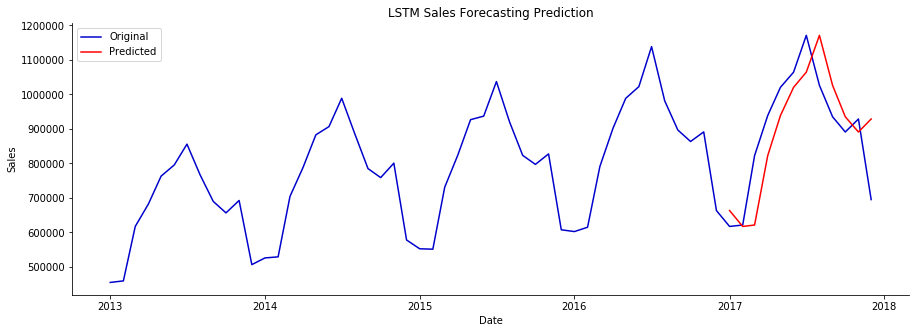

In [112]:
lstm_model(train, test)

### Arima

In [113]:

def generate_arima_data(data):
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    dt_data.to_csv('../data/arima_df.csv')
    
    return dt_data

arima_df = generate_arima_data(monthly_diff)

In [120]:
arima_df.index = pd.to_datetime(arima_df.index)

In [121]:
 def get_scores(data):   
    model_scores = {}
    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.forecast[-12:]))
    mae = mean_absolute_error(data.sales_diff[-12:], data.forecast[-12:])
    r2 = r2_score(data.sales_diff[-12:], data.forecast[-12:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    

C:\Users\higgleop\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\higgleop\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 14959.893467243508
MAE: 11265.33574870509
R2 Score: 0.9835642876212577


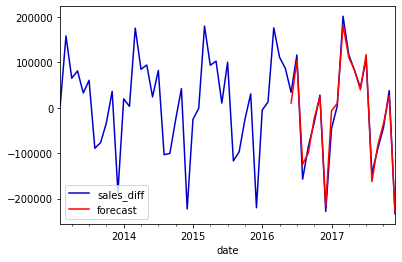

In [127]:
def sarimax_model(data):
    
    # Model
    sar = sm.tsa.statespace.SARIMAX(data.sales_diff, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()

    # Predictions
    start, end, dynamic = 40, 100, 7
    data['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic) 
    pred_df = data.forecast[start+dynamic:end]
    
    data[['sales_diff', 'forecast']].plot(color=['mediumblue', 'Red'])
    
    get_scores(data)

    return sar, data, pred_df

sar, arima_df, predictions = sarimax_model(arima_df)

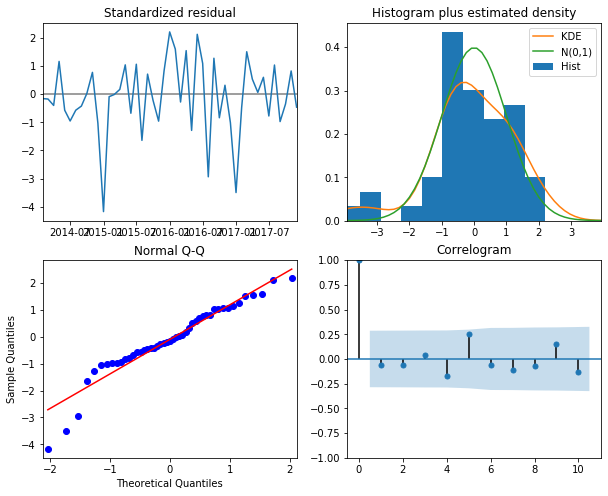

In [128]:
sar.plot_diagnostics(figsize=(10, 8));

In [129]:
def predict_arima_df(prediction_df):
    
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('data/demand-forecasting/train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(prediction_df)):
        result_dict = {}
        result_dict['pred_value'] = int(prediction_df[index] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result, original_df

In [130]:
prediction_df, original_df = predict_arima_df(predictions)

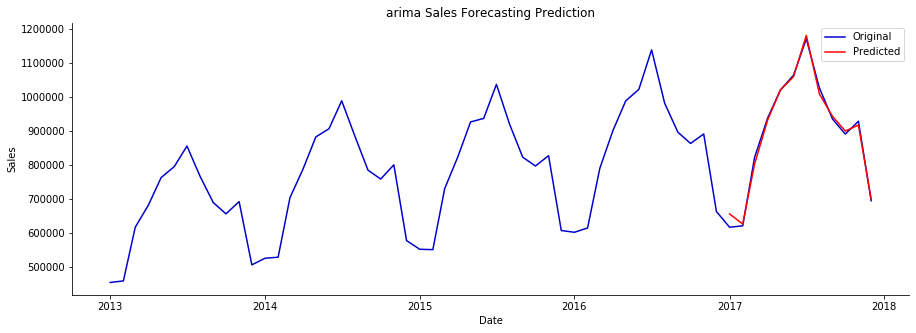

In [131]:
plot_results(prediction_df, original_df, 'arima')